## AI Agent智能应用从0到1定制开发 
## AI Agent Intelligent Application Custom Development from 0 to 1
******
- 此代码为网课《AI Agent智能应用从0到1定制开发》的配套代码，需要注意本套代码建议与网课适配配合食用。
- This code for the online course <AI Agent Intelligent Applications from 0 to 1 custom development> supporting code, need to pay attention to this set of code is recommended with the online course adapted to work with consumption.
- 需要注意由于课程开发周期的原因，langchain版本跨越了3个大版本，部分代码会与视频演示有差别!
- Note that due to the course development cycle, the langchain version spans 3 major releases and some of the code will differ from the video demo!
- 课程地址：https://coding.imooc.com/class/822.html
- Course address: https://coding.imooc.com/class/822.html

### 从环境变量中读取密钥
### Read the key from the environment variable
- 注意：尽量将你的OpenAI Key存储在类似.env文件中，而不是明文暴露在代码里，这是一种基本的安全措施
- Note: Try to store your OpenAI Key in something like an .env file, rather than exposing it explicitly in code, as a basic safety measure!
******

In [9]:

import os
from dotenv import load_dotenv
# Load environment variables from openai.env file
load_dotenv("asset/openai.env")

# Read the OPENAI_API_KEY from the environment
api_key = os.getenv("OPENAI_API_KEY")
api_base = os.getenv("OPENAI_API_BASE")
os.environ["OPENAI_API_KEY"] = api_key
os.environ["OPENAI_API_BASE"] = api_base
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")
os.environ["ELEVEN_API_KEY"] = os.getenv("ELEVEN_API_KEY")
os.environ["AZURE_COGS_KEY"] = os.getenv("AZURE_COGS_KEY")
os.environ["AZURE_COGS_ENDPOINT"] = os.getenv("AZURE_COGS_ENDPOINT")
os.environ["AZURE_COGS_REGION"] = os.getenv("AZURE_COGS_REGION")
os.environ["DASHSCOPE_API_KEY"] = os.getenv("DASHSCOPE_API_KEY")
os.environ["ZHIPUAI_API_KEY"] = os.getenv("ZHIPUAI_API_KEY")
zhipukey =  os.getenv("ZHIPUAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["MOONSHOT_API_KEY"] = os.getenv("MoonShot_key")
MoonShot_key = os.getenv("MoonShot_key")
os.environ["BAICHUAN_API_KEY"] = os.getenv("BAICHUAN_API_KEY")
baichuankey = os.getenv("BAICHUAN_API_KEY")

### LangGraph Double agents
****

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "UK GDP data 2018-2022"}', 'name': 'tavily_search_results_json'}, 'id': 'call_9073581754233124649', 'index': 0, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 287, 'total_tokens': 309}, 'model_name': 'GLM-4-Plus', 'finish_reason': 'tool_calls'}, name='Researcher', id='run-f32217be-2f1b-4276-bd6a-1ad69ec35e72-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP data 2018-2022'}, 'id': 'call_9073581754233124649', 'type': 'tool_call'}])], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://www.macrotrends.net/global-metrics/countries/GBR/united-kingdom/gdp-gross-domestic-product", "content": "U.K. gdp for 2022 was $3,089.07B, a 1.67% decline from 2021. U.K. gdp for 2021 was $3,141.51B, a 16.45% increase from 2020. U.K. gdp for 2020 was $2,697.8

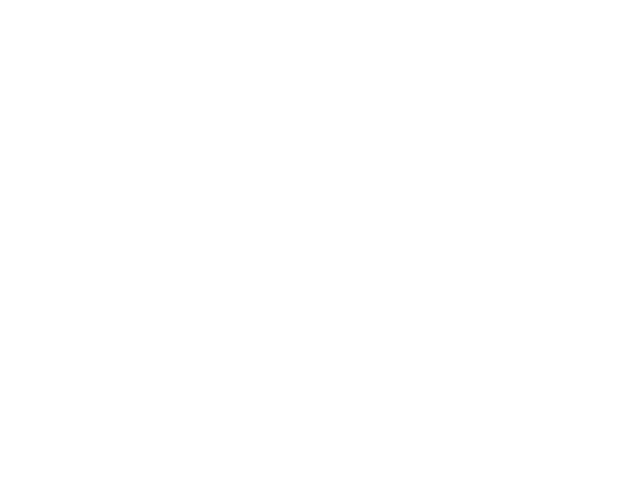

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# GDP data for the UK from 2018 to 2022\nyears = ['2018', '2019', '2020', '2021', '2022']\ngdp_values = [2802.92, 2851.41, 2697.81, 3141.51, 3089.07]  # in billion USD\n\n# Creating the line graph\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker='o', color='b')\nplt.title('UK GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (Billion USD)')\nplt.grid(True)\nplt.tight_layout()\n\n# Saving the graph as an image file\nplt.savefig('uk_gdp_over_5_years.png')\nplt.close()\n```\nChart saved as: chart_0fc3e1ece05c4e9c84d169b7a549acd0.png\n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_9073575260241163884')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER\n\nThe line graph depicting the UK's GDP over the past 5 years has been created and saved as an image file. You ca

In [18]:
from langchain_core.messages import (
    BaseMessage,
    ToolMessage,
    HumanMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph

from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

import operator
from typing import Annotated, Sequence, TypedDict

from langchain_community.chat_models import  ChatZhipuAI
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage
from langgraph.prebuilt import ToolNode
import functools
from typing import Literal
import matplotlib.pyplot as plt
import uuid



def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You are a helpful AI assistant, collaborating with other assistants."
            " Use the provided tools to progress towards answering the question."
            " If you are unable to fully answer, that's OK, another assistant with different tools "
            " will help where you left off. Execute what you can to make progress."
            " If you or any of the other assistants have the final answer or deliverable,"
            " prefix your response with FINAL ANSWER so the team knows to stop."
            " You have access to the following tools: {tool_names}.\n{system_message}",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ])
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name
                                                  for tool in tools]))
    return prompt | llm.bind_tools(tools)

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()
@tool
def python_repl(
    code: Annotated[str,
                    "The python code to execute to generate your chart."]):
    """Use it to execute python code and save the resulting chart as an image file in the current directory."""
    try:
        # Generate a unique filename for the chart image
        filename = f"chart_{uuid.uuid4().hex}.png"

        # Execute the code
        exec(code)

        # Save the chart as an image file
        plt.savefig(filename)
        plt.close()

        result_str = f"Successfully executed:\n```python\n{code}\n```\nChart saved as: {filename}"
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    return (result_str +
            "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")


#定义状态
# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


#定义agent节点
# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

llm = ChatZhipuAI(   
    model="GLM-4-Plus",
    temperature=0
)

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message=
    "You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node,
                                  agent=research_agent,
                                  name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node,
                               agent=chart_agent,
                               name="chart_generator")

#定义工具节点
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

#定义边逻辑
# Either agent can decide to end


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"


#设置图表
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {
        "continue": "chart_generator",
        "call_tool": "call_tool",
        "__end__": END
    },
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {
        "continue": "Researcher",
        "call_tool": "call_tool",
        "__end__": END
    },
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

#搜索并绘制
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the UK's GDP over the past 5 years,"
                         " then draw a line graph of it and save image."
                         " Once you saved image, finish.")
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")